In [1]:
import numpy as np 
import pandas as pd 
import os

import torch
import torchvision.transforms as transforms 
from torch.utils.data import Subset 
import torch.nn as nn  
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader, Dataset 
import torch.optim as optim 
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms

from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import random
from PIL import Image

# Problem

This workbook evaluates CNN to improve detection of malignant cancer cells in a large set of images that contain healthy and malignant cells that are labeled as such.

# EDA

In [2]:
directory_path = 'train'
items = os.listdir(directory_path)
item_count = len(items)
print(f'The number of items in the train directory is: {item_count}')

The number of items in the train directory is: 220025


In [3]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.shape

(220025, 2)

In [4]:
train_labels[train_labels.duplicated(keep=False)]['label'].value_counts()

Series([], Name: count, dtype: int64)

In [5]:
missing_values = train_labels.isnull().sum()
missing_values

id       0
label    0
dtype: int64

<Axes: >

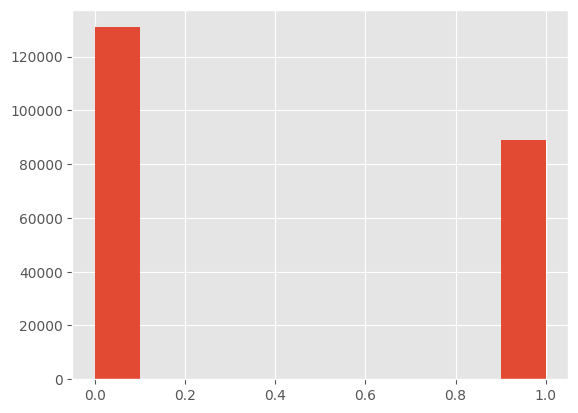

In [6]:
def plot_fig(ids,title,nrows=3,ncols=3):

    fig,ax = plt.subplots(nrows,ncols,figsize=(7,7))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(train ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

malignant = train_labels.loc[train_labels['label']==1]['id'].values    
normal = train_labels.loc[train_labels['label']==0]['id'].values      
train_labels['label'].hist()

The train data set has 220025 total images, of which 130098 are non-cancerous and 89117 are cancerous. There are no duplicates or missing values.

In [7]:
directory_path = 'test'
items = os.listdir(directory_path)
item_count = len(items)
print(f'The number of items in the test directory is: {item_count}')

The number of items in the test directory is: 57458


In [8]:
test_images = 'test/'

test_df = pd.read_csv('sample_submission.csv')

test_df['id'] = test_df['id'] + '.tif'
test_df['label'] = test_df['label'].astype(str)

print('Test Set Size:', test_df.shape)
test_df.shape

Test Set Size: (57458, 2)


(57458, 2)

In [9]:
test_df['label'].value_counts()

label
0    57458
Name: count, dtype: int64

In [10]:
def plot_fig(train_path, ids, title, nrows=3, ncols=3):
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 12))  # Adjust size as needed
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust spacing as needed
    for i, ax in enumerate(axs.flatten()):
        if i >= len(ids):
            break
        fname = os.path.join(train_path, ids[i] + '.tif')
        img = Image.open(fname)
        ax.imshow(np.array(img))
        ax.axis('off')  # Hide axis
    plt.suptitle(title, fontsize=16)
    plt.show()

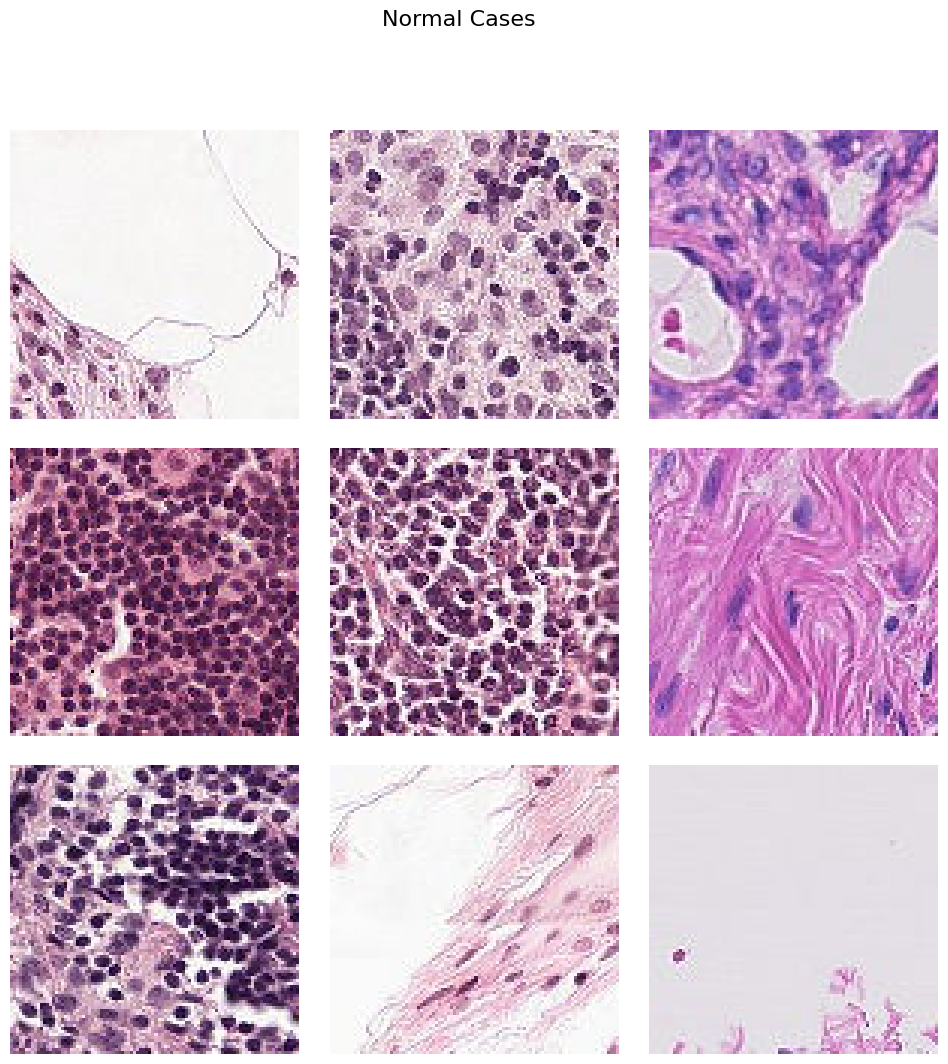

In [11]:
train_path = 'train/'
plot_fig(train_path, normal[:9], 'Normal Cases', nrows=3, ncols=3)

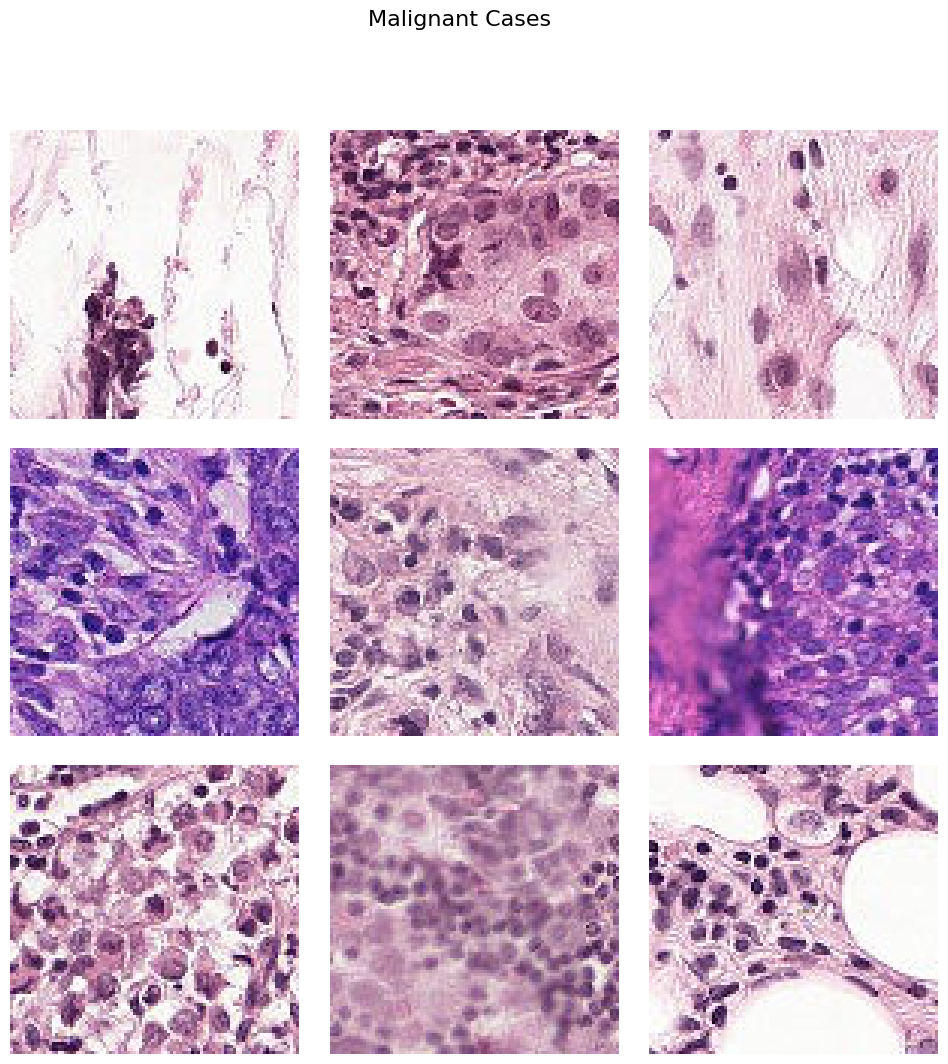

In [12]:
plot_fig(train_path, malignant[:9], 'Malignant Cases', nrows=3, ncols=3)

Importantly, the test set is unbalanced, as there are only 0 (non-cancerous) labels. With no 1 labels, this implies that the nature of this study is to verify the CNN model performance in correctly identifying negatives. The ideal result on test data should be no malignant cells detected - ie. no false positives. 

Therefore, the plan is to creat train, validation split on the train data set and then do a final test on the test data set to assure minimal false negatives.

In [17]:
train_data, val_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])

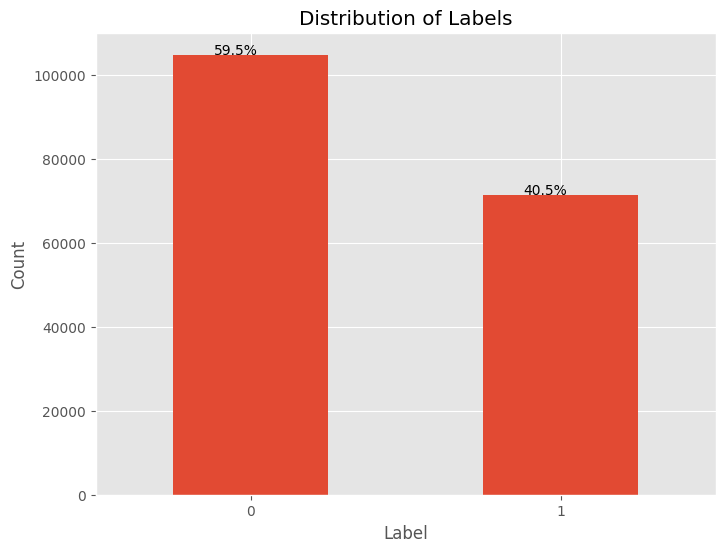

In [18]:
label_counts = train_data['label'].value_counts()

# histogram
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# % label
total = len(train_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + total * 0.001
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

The training data is imbalanced, with more normal cases than malignant cases. 

# Model Architecture

The model architecture features a series of convolutional layers designed to progressively increase the depth while maintaining spatial dimensions using padding. Each convolutional layer is followed by batch normalization and ReLU activation, enhancing training stability and non-linearity. After each set of convolutions, spatial dimension reduction is achieved through max pooling, condensing the feature maps and reducing computational load. The network concludes with fully connected layers, transforming the learned spatial features into class predictions, and incorporates dropout to mitigate overfitting. Hyperparameter tuning is conducted via learning rate scheduling. 

In [20]:
# Create a transform to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize((96, 96)),  
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# Create a transform to resize and normalize the images
class CancerImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe  
        self.img_dir = img_dir      
        self.transform = transform  

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']  
        label = self.dataframe.iloc[idx]['label']  

        img_path = os.path.join(self.img_dir, img_id + '.tif')
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [21]:
# Logic to configure data set size as a hyperparameter
random.seed(42)

img_dir = "train" 
train_dataset = CancerImageDataset(dataframe=train_data, img_dir=img_dir, transform=transform)
val_dataset= CancerImageDataset(dataframe=val_data, img_dir=img_dir, transform=transform)

train_size = len(train_dataset)
val_size = len(val_dataset)

train_sample_size = int(train_size * 0.15)
val_sample_size = int(val_size * 0.15)

# Generate random indexes
train_indexs = random.sample(range(train_size), train_sample_size)
val_indexs = random.sample(range(val_size), val_sample_size)

# Create subsets
train_subset = Subset(train_dataset, train_indexs)
val_subset = Subset(val_dataset, val_indexs)

# Assign subsets to the original datasets
train_dataset = train_subset
val_dataset = val_subset

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=2048, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=False, pin_memory=True)

# Verify data upload
for imgs, labels in train_dataloader:
    print(imgs.shape)  
    print(labels.shape)  
    break  

torch.Size([2048, 3, 96, 96])
torch.Size([2048])


In [24]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Convolutional layer 1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Convolutional layer 2
        self.fc1 = nn.Linear(32 * 24 * 24, 128)  # Fully-connected layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with a probability of 0.5
        self.fc2 = nn.Linear(128, 2)  # Output layer (2 labels: with and without cancer)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1 and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2 and pooling
        x = x.view(-1, 32 * 24 * 24)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully-connected layer
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer
        return x

model = CNN()

In [25]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = CNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model training
num_epochs = 6
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode
    for images, labels in train_dataloader:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        # Clean gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward propagation and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Validation phase
    correct = 0
    total = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            # Move data to the device
            val_images, val_labels = val_images.to(device), val_labels.to(device)

            # Forward propagation
            val_outputs = model(val_images)

            # Obtain predictions
            predicted = torch.argmax(val_outputs, 1)

            # Total number of correct predictions
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}, Accuracy: {accuracy:.2f}%')


Using device: cuda
Epoch [1/6], Loss: 1.0255, Accuracy: 60.71%
Epoch [2/6], Loss: 0.6475, Accuracy: 60.71%
Epoch [3/6], Loss: 0.5998, Accuracy: 75.82%
Epoch [4/6], Loss: 0.5674, Accuracy: 76.82%
Epoch [5/6], Loss: 0.5533, Accuracy: 77.20%
Epoch [6/6], Loss: 0.5455, Accuracy: 77.44%


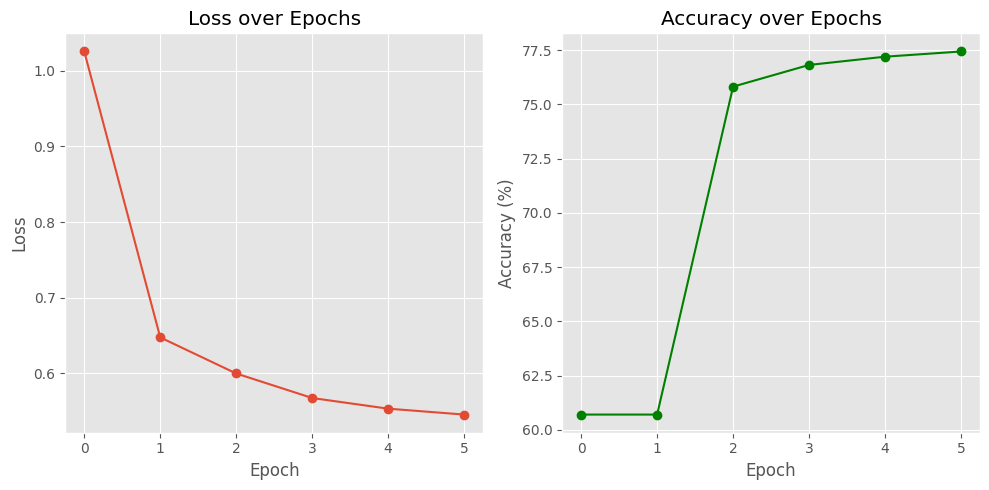

In [28]:
results_df = pd.DataFrame({
    'Epoch': [0,1,2,3,4,5],
    'Loss': [1.0255, 0.6475, 0.5998, 0.5674, 0.5533, 0.5455],
    'Accuracy': [60.71, 60.71, 75.82, 76.82, 77.20, 77.44]
})

# Plotting loss over epochs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results_df['Epoch'], results_df['Loss'], marker='o', label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plotting accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(results_df['Epoch'], results_df['Accuracy'], marker='o', color='green', label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Your existing CNN model instantiation and moving it to the device
model = CNN().to(device)

class CancerTestDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.image_files_list = sorted(os.listdir(data_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = self.image_files_list[idx]
        img_path = os.path.join(self.data_folder, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        img_id = img_name.split('.')[0] 
        return image, img_id

# Instantiate the Dataset and DataLoader for the test set
test_dataset = CancerTestDataset(data_folder='test/', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=True) # Adjust batch size if needed

# Generate predictions on the test set
model.eval()
preds = []
image_ids = []
with torch.no_grad():
    for inputs, img_ids in test_dataloader:
        inputs = inputs.to(device)  # Move inputs to GPU
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs[:, 1])  # Apply sigmoid to get probabilities
        probabilities = probabilities.cpu().numpy()  # Move probabilities back to CPU for further processing
        preds.extend(probabilities)
        image_ids.extend(img_ids)

# Create a DataFrame with image IDs and predictions
import pandas as pd
submission = pd.DataFrame({'id': image_ids, 'label': preds})
submission['label'] = submission['label'].clip(0, 1)  # Ensure predictions are in [0, 1]
print(submission.head())


Using device: cuda
                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.521116
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.508864
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.513101
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.511110
4  000270442cc15af719583a8172c87cd2bd9c7746  0.519272


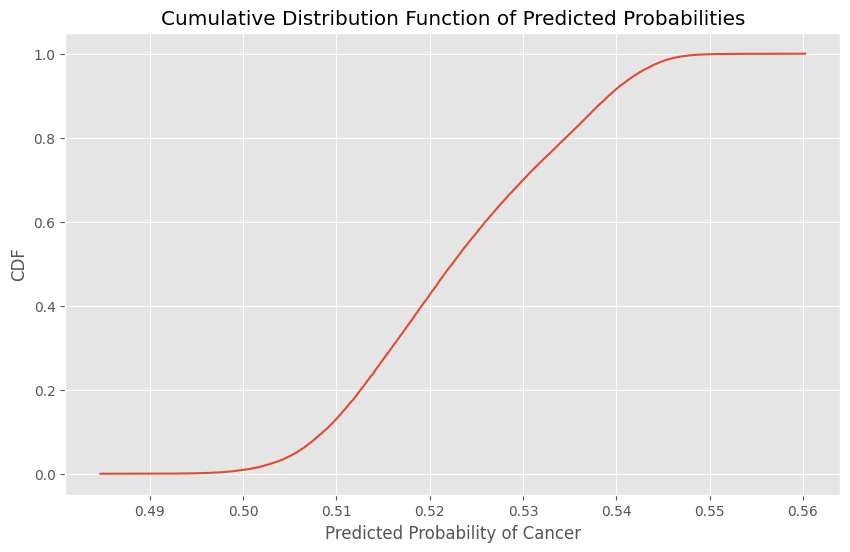

In [31]:
import numpy as np

# Calculating the CDF
data_sorted = np.sort(submission['label'])
p = 1. * np.arange(len(submission['label'])) / (len(submission['label']) - 1)

plt.figure(figsize=(10, 6))
plt.plot(data_sorted, p)
plt.title('Cumulative Distribution Function of Predicted Probabilities')
plt.xlabel('Predicted Probability of Cancer')
plt.ylabel('CDF')
plt.grid(True)
plt.show()

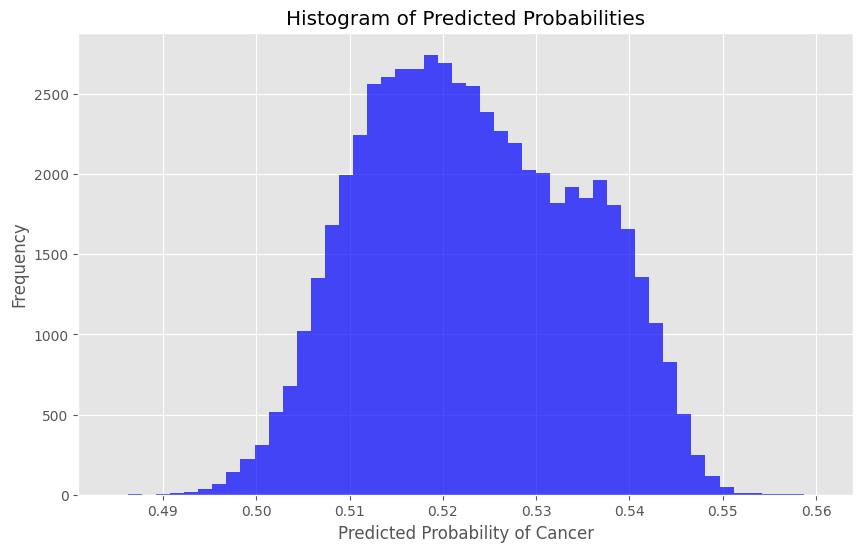

In [35]:
import matplotlib.pyplot as plt

# Plotting the histogram of the predicted probabilities
plt.figure(figsize=(10, 6))
plt.hist(submission['label'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Cancer')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Conclusion

This histogram of predicted probabilities illustrates that the model predominantly assigns probabilities close to 0.50 with a peak slightly above this midpoint. Given that the actual dataset contains only negative cases (all 0's, no 1's), the ideal model should produce probabilities skewed significantly towards 0. Therefore the model is overestimating the likelihood of cancer. 

To improve model performance, next steps would be to increase sample size and epochs, increase batch size, and then incrementally tune model parameters, starting with learning rate. 